# CA05-A-Logistic_Regression

## Import Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

## Load Data and Build the Model

In [2]:
df = pd.read_csv('https://github.com/ArinB/CA05-B-Logistic-Regression/raw/master/cvd_data.csv')
df.head()

,cvd_4types,age_s1,race,educat,mstat,hip,neck20,waist,av_weight_kg,cgpkyr,tea15,srhype,parrptdiab,bend25,happy25,tired25,hlthlm25
0,0,54,1,2,1,110.0,40.0,108.0,87.5,34.0,0,1,0,1,2,3,4
1,0,56,3,2,1,113.0,34.0,107.0,83.5,0.0,0,0,0,2,2,1,3
2,0,54,1,3,1,110.0,44.5,105.0,86.2,49.5,0,0,0,3,2,6,4
3,0,54,1,3,1,129.0,42.5,110.0,89.1,0.0,0,0,0,3,2,1,3
4,0,51,3,2,1,122.0,37.0,113.0,81.3,0.0,0,0,0,2,1,1,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 17 columns):
cvd_4types      3242 non-null int64
age_s1          3242 non-null int64
race            3242 non-null int64
educat          3242 non-null int64
mstat           3242 non-null int64
hip             3242 non-null float64
neck20          3242 non-null float64
waist           3242 non-null float64
av_weight_kg    3242 non-null float64
cgpkyr          3242 non-null float64
tea15           3242 non-null int64
srhype          3242 non-null int64
parrptdiab      3242 non-null int64
bend25          3242 non-null int64
happy25         3242 non-null int64
tired25         3242 non-null int64
hlthlm25        3242 non-null int64
dtypes: float64(5), int64(12)
memory usage: 430.7 KB


In [5]:
df.describe()

,cvd_4types,age_s1,race,educat,mstat,hip,neck20,waist,av_weight_kg,cgpkyr,tea15,srhype,parrptdiab,bend25,happy25,tired25,hlthlm25
count,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000
mean,0.590068,64.828809,1.094695,2.326342,1.368600,105.404832,37.550719,97.209904,82.945928,12.904010,0.430907,0.327884,0.067551,2.473782,2.281308,4.292721,3.864898
std,0.491897,10.400496,0.358237,0.697934,0.933871,10.280402,4.101003,13.598060,7.849650,20.156736,1.242444,0.469515,0.251012,0.672158,0.951695,1.021099,0.614247
min,0.000000,39.000000,1.000000,1.000000,1.000000,44.000000,25.000000,67.000000,57.400000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,57.000000,1.000000,2.000000,1.000000,99.000000,34.425000,88.000000,78.200000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000
50%,1.000000,65.000000,1.000000,2.000000,1.000000,104.000000,37.150000,97.000000,82.550000,0.300000,0.000000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
75%,1.000000,73.000000,1.000000,3.000000,1.000000,110.000000,40.500000,106.000000,86.575000,20.475000,0.000000,1.000000,0.000000,3.000000,3.000000,5.000000,4.000000
max,1.000000,90.000000,3.000000,4.000000,8.000000,168.000000,53.000000,135.000000,136.700000,170.500000,30.000000,1.000000,1.000000,3.000000,6.000000,6.000000,5.000000


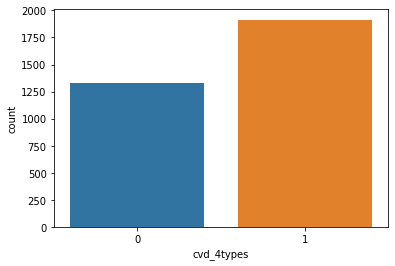

In [9]:
# See if we got an imbalanced data
sns.countplot(df['cvd_4types'])

### Feature Engineering

In [22]:
# specify the categorical columns
cat_features = ['race', 'educat','mstat','tea15', 'srhype', 'parrptdiab','bend25', 'happy25', 'tired25', 'hlthlm25']

In [100]:
df_dum = pd.get_dummies(data=df, columns=cat_features, drop_first=True)

In [101]:
# This function could normalize the numerical data
def normalize(value):
    norm = (value - value.mean()) / (value.max() - value.min())
    return norm

In [102]:
# Normalize the numerical variable to make their scales the same
norm_columns = ['age_s1','hip', 'neck20','waist', 'av_weight_kg', 'cgpkyr']
df_dum[norm_columns]=df_dum[norm_columns].apply(normalize)

In [103]:
df_dum.head()

,cvd_4types,age_s1,hip,neck20,waist,av_weight_kg,cgpkyr,race_2,race_3,educat_2,...,happy25_6,tired25_2,tired25_3,tired25_4,tired25_5,tired25_6,hlthlm25_2,hlthlm25_3,hlthlm25_4,hlthlm25_5
0,0,-0.212330,0.037058,0.087474,0.158678,0.057428,0.123730,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,0,-0.173114,0.061251,-0.126811,0.143972,0.006987,-0.075683,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,0,-0.212330,0.037058,0.248189,0.114560,0.041035,0.214639,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,-0.212330,0.190284,0.176760,0.188090,0.077605,-0.075683,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,-0.271153,0.133832,-0.019669,0.232207,-0.020756,-0.075683,0,1,1,...,0,0,0,0,0,0,1,0,0,0


In [104]:
# Split the data set by specify the size as 0.3
X_train, X_test, y_train, y_test = train_test_split(df_dum.drop('cvd_4types',axis=1)
                                                    , df_dum['cvd_4types'], test_size=0.3, random_state=42)

### Train the model without specify the hyperparameters

In [132]:
lr = LogisticRegression(max_iter = 4000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

C:\Users\wuuj0\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6875642343268242

### Use GridSearch to find the best hyperparameter

In [133]:
# Create regularization hyperparameter space
C = np.logspace(-4, 4, 20)

# Create penalty and solver space
solver = ['sag','lbfgs','newton-cg']

# Create hyperparameter options
random_state = [42]
hyperparameters = dict(C=C, solver=solver, random_state=random_state)

In [134]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(lr, hyperparameters, cv=5)

In [135]:
best_model = clf.fit(X_train, y_train)

In [136]:
# View best hyperparameters
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Solver: sag
Best C: 545.5594781168514


### Re-train the model

In [138]:
lr = LogisticRegression(C=545.6, solver='sag', random_state=42, max_iter=4000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
# The accuracy did increase, but it isn't significant
acc

0.6937307297019527

### Feature Importance

In [139]:
stand_coef = np.std(X_train,0)*lr.coef_[0]
print(stand_coef)

age_s1         -0.065637
hip            -0.598369
neck20         -0.136464
waist           1.018674
av_weight_kg   -0.126978
cgpkyr         -0.022828
race_2         -0.242731
race_3         -0.377089
educat_2       -0.169016
educat_3       -0.099945
educat_4        0.214619
mstat_2        -0.190880
mstat_3        -0.081223
mstat_4        -0.318663
mstat_8         0.588755
tea15_1        -0.084229
tea15_2        -0.007785
tea15_3         0.011179
tea15_4        -0.018447
tea15_5        -0.016424
tea15_6         0.038345
tea15_7         0.168167
tea15_8        -0.009411
tea15_9         0.071410
tea15_10       -0.064737
tea15_12       -0.130462
tea15_16       -0.127769
tea15_21       -0.111139
tea15_30       -0.122936
srhype_1        0.029836
parrptdiab_1    0.184120
bend25_2        0.121659
bend25_3        0.028905
happy25_2       0.110103
happy25_3       0.050786
happy25_4      -0.017580
happy25_5       0.021543
happy25_6       0.014713
tired25_2      -0.092641
tired25_3      -0.130858


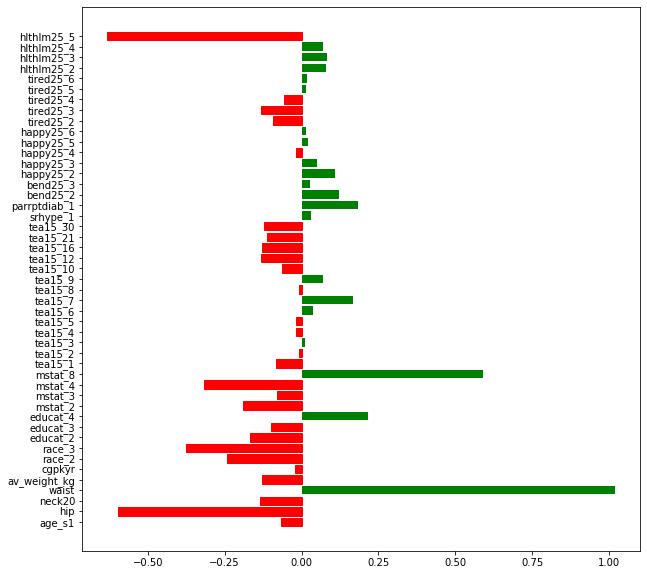

In [140]:
plt.figure(figsize=(10,10))
barlist = plt.barh(stand_coef.index,stand_coef,color='g')
for i,coef in enumerate(lr.coef_[0]):
    if coef<0:
        barlist[i].set_color('r')
    else: pass
# The green factors would increase the probability of being 1 and vice versa

### Model Evaluation

In [141]:
y_score = lr.predict_proba(X_test)[:,1]

Text(0, 0.5, 'True Positive Rate')

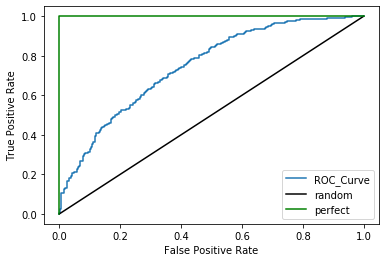

In [142]:
fp, tp, threshold = roc_curve(y_test, y_score)
plt.plot(fp, tp,label = 'ROC_Curve')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# The ROC curve is only a little bit better than the random line

In [143]:
auc_lr = roc_auc_score(y_test, y_score)
print("The AUC for the Logistic Regression is {}".format(round(auc_lr,4)))

The AUC for the Logistic Regression is 0.7461


# CA05-B-KNN

In [19]:
from sklearn.neighbors import NearestNeighbors

In [20]:
movie = pd.read_csv('https://github.com/ArinB/CA05-kNN/raw/master/movies_recommendation_data.csv')
movie.head()

,Movie ID,Movie Name,IMDB Rating,Biography,Drama,Thriller,Comedy,Crime,Mystery,History,Label
0,58,The Imitation Game,8.0,1,1,1,0,0,0,0,0
1,8,Ex Machina,7.7,0,1,0,0,0,1,0,0
2,46,A Beautiful Mind,8.2,1,1,0,0,0,0,0,0
3,62,Good Will Hunting,8.3,0,1,0,0,0,0,0,0
4,97,Forrest Gump,8.8,0,1,0,0,0,0,0,0


In [21]:
# get rid of unnecessary columns without destroying the original structure
df = movie.copy()
df.drop(['Movie ID', 'Movie Name', 'Label'], axis = 1,inplace = True)

### Build the recommendation and show the result

In [22]:
# The goal is to recommend five similiar movie, so the n_neighbors is 5
nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(df)

# Next we find k nearest neighbor for each point in df.
distances, indices = nbrs.kneighbors(df)

In [23]:
print(indices[:10])
# The first number in each array is their index
# Start from the second number would be their nearest neighbers' indices respectively

[[ 0  2 16 29 28]
 [ 1  6 21 18 10]
 [ 2 16 29 27 28]
 [ 3 12  4  6 18]
 [ 4 12  3 15 17]
 [ 5 10  9 21 18]
 [ 6 18 21 10  9]
 [ 7 20 10  9 18]
 [ 8 22 24 14 19]
 [ 9 10 18 21  6]]


In [25]:
# the function that could show 4 recommendations for each movie
def all_recommend(movie_df):
    mov_series = movie_df['Movie Name']
    whole_recommend = []
    for single_movie in indices:
        recomm_movie = []
        for recommend_indices in single_movie:
            movie_name = mov_series.iloc[recommend_indices]
            recomm_movie.append(movie_name)
        whole_recommend.append(recomm_movie)
    movie_dict = {}
    for movie_i in whole_recommend:
        movie = movie_i[0]
        recommendation = movie_i[1:]
        movie_dict[movie] = recommendation
    recommend_df = pd.DataFrame(movie_dict).transpose().rename(columns={0:'1st recommendation',1:'2nd recommendation',
                                                         2:'3rd recommendation',3:'4th recommendation'})
    return recommend_df

In [28]:
all_recommend(movie).head(10)

,1st recommendation,2nd recommendation,3rd recommendation,4th recommendation
The Imitation Game,A Beautiful Mind,The Wind Rises,Queen of Katwe,12 Years a Slave
Ex Machina,Gifted,Stand and Deliver,Finding Forrester,A Brilliant Young Mind
A Beautiful Mind,The Wind Rises,Queen of Katwe,Hacksaw Ridge,12 Years a Slave
Good Will Hunting,Interstellar,Forrest Gump,Gifted,Finding Forrester
Forrest Gump,Interstellar,Good Will Hunting,Inception,Spirited Away
21,A Brilliant Young Mind,The Karate Kid,Stand and Deliver,Finding Forrester
Gifted,Finding Forrester,Stand and Deliver,A Brilliant Young Mind,The Karate Kid
Travelling Salesman,The DaVinci Code,A Brilliant Young Mind,The Karate Kid,Finding Forrester
Avatar,The Terminator,The Avengers,Black Panther,The Fountain
The Karate Kid,A Brilliant Young Mind,Finding Forrester,Stand and Deliver,Gifted


In [312]:
# This function could allow you to search movies' recommendation
def search_recommend(movie_name):
    df = all_recommend(movie)
    return df.loc[movie_name,:]

In [317]:
search_recommend(['The Imitation Game','Ex Machina'])

,1st recommendation,2nd recommendation,3rd recommendation,4th recommendation
The Imitation Game,A Beautiful Mind,The Wind Rises,Queen of Katwe,12 Years a Slave
Ex Machina,Gifted,Stand and Deliver,Finding Forrester,A Brilliant Young Mind


### Recommendation for "The Post"

In [164]:
the_post = [7.2, 1, 1, 0, 0, 0, 0, 1]
distances_n, indices_n = nbrs.kneighbors([the_post])
print(indices_n)
# These are the five most nearest movies' indices
# Different from the indices above that start from the second number
# "The Post" is a new record that hasn't been trained in the fitted model
# Therefore, the first number is the 1st recommendation in the model instead of its index

[[28 27 29 16  2]]


In [260]:
def get_recommend(movie_feature_vector):       
    mov_series = movie['Movie Name']
    distances_n, indices_n = nbrs.kneighbors([movie_feature_vector])
    recommend_movie = []
    for i in indices_n[0]:
        movie_name = mov_series.iloc[i]
        recommend_movie.append(movie_name)
    return recommend_movie

In [269]:
get_recommend(the_post)

['12 Years a Slave',
 'Hacksaw Ridge',
 'Queen of Katwe',
 'The Wind Rises',
 'A Beautiful Mind']

In [268]:
for i,movie_n in enumerate(get_recommend(the_post)):
    # make i = i+1 so the i could start from 1 instead of 0
    i+=1
    print('The {} recommendation is {}'.format(i,movie_n))


The 1 recommendation is 12 Years a Slave
The 2 recommendation is Hacksaw Ridge
The 3 recommendation is Queen of Katwe
The 4 recommendation is The Wind Rises
The 5 recommendation is A Beautiful Mind
